In [10]:
import pandas as pd
import numpy as np
from datetime import datetime

### SCORE FINAL

In [11]:
## Inicializar variables

lambda_Shostil = 0
lambda_Slead = 0.4
lambda_Smaduracion = 0
lambda_Stiming = 0

In [ ]:
"""
'cliente' | 'interaccion_positivida' | 'interaccion_negativa' | 'fecha_interacciones' | 'duracion[s]' 

2617013574 [0.68, 0.56, 0.45] [0.08, 0.10, 0.20] [2023-10-01, 2023-10-17, 2023-10-30] [60, 600, 150] 
266999014 [0.12, 0.10] [0.20, 0.35] [2023-10-28, 2023-10-30] [60, 360]
"""

In [45]:
# Funciones auxiliares

def decaimiento_exp(delta_t, lambda_S) -> float:
    """Calcula el decaimiento exponencial para un intervalo de tiempo dado."""
    if delta_t < 0  or lambda_S < 0:
        raise ValueError("Los valores de delta_t, duracion y lambda deben ser no negativos, y duracion debe ser mayor que cero.")
    return np.exp(-lambda_S * (delta_t))


def funcion_sigmoide(delta_t, lambda_S, b) -> float:
    """Calcula el valor de la función sigmoide para un intervalo de tiempo dado."""
    if delta_t < 0:
        raise ValueError("Los valores de delta_t, lambda y b deben ser no negativos.")
    return 1 / (1 + np.exp(-lambda_S*delta_t + b))


def factor_de_desgaste(n_ultimos_15dias, n_max) -> float:
    if n_ultimos_15dias < 0 or n_max <= 0:
        raise ValueError("Los valores deben ser no negativos y n_max > 0.")
    ratio = n_ultimos_15dias / n_max
    return 1 - min(1, ratio)


def pendiente(x, y) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if x.size != y.size:
        raise ValueError("Las listas deben tener la misma longitud.")
    if x.size == 0:
        raise ValueError("Las listas no pueden estar vacías.")

    x_mean = x.mean()
    y_mean = y.mean()
    cov_xy = (x * y).mean() - x_mean * y_mean
    var_x  = (x * x).mean() - x_mean**2

    if var_x == 0:
        raise ValueError("La varianza de x no puede ser cero.")

    return cov_xy / var_x


In [44]:

def score_log_boost(inter_pos, fechas, duraciones,
                    lambda_S=0.05, alpha=0.1, referencia=None):
    """
    Opción A — boost logarítmico por duración:
      g(dur) = 1 + alpha * log(1 + dur)

    Parámetros:
    - inter_pos: list/array de scores positivos por interacción
    - fechas: list de ISO strings o datetime
    - duraciones: list/array de duraciones en segundos
    - lambda_S: decaimiento por día
    - alpha: fuerza del boost logarítmico
    - referencia: datetime de referencia (por defecto now)

    Retorna: score normalizado (promedio ponderado)
    """
    inter = np.asarray(inter_pos, dtype=float)
    dur = np.asarray(duraciones, dtype=float)
    fechas_dt = [datetime.fromisoformat(f) if isinstance(f, str) else f for f in fechas]
    
    if referencia is None:
        referencia = datetime.now()

    dias = np.array([(referencia - f).days for f in fechas_dt], dtype=float)
    if np.any(dias < 0):
        raise ValueError("Alguna fecha está en el futuro respecto a la referencia.")

    # Usar decaimiento_exp en lugar de np.exp directamente
    w_time = np.array([decaimiento_exp(d, lambda_S) for d in dias])
    
    gA = 1 + alpha * np.log(1 + dur)         # boost suave
    pesos = w_time * gA
    s = np.sum(pesos)
    return float(np.sum(pesos * inter) / s) if s != 0 else 0.0

def score_frac_boost(inter_pos, fechas, duraciones,
                     lambda_S=0.05, C=600.0, referencia=None):
    """
    Opción B — boost por fracción con amplificación:
      g(dur) = 1 + dur / (dur + C)
      
    Ahora el boost puede superar 1.0 y aumentar el peso base.

    Parámetros:
    - inter_pos: list/array de scores positivos por interacción
    - fechas: list de ISO strings o datetime
    - duraciones: list/array de duraciones en segundos
    - lambda_S: decaimiento por día
    - C: constante de saturación (en segundos)
    - referencia: datetime de referencia (por defecto now)
    
    Retorna: score normalizado (promedio ponderado)
    """
    inter = np.asarray(inter_pos, dtype=float)
    dur = np.asarray(duraciones, dtype=float)
    fechas_dt = [datetime.fromisoformat(f) if isinstance(f, str) else f for f in fechas]
    
    if referencia is None:
        referencia = datetime.now()

    dias = np.array([(referencia - f).days for f in fechas_dt], dtype=float)
    if np.any(dias < 0):
        raise ValueError("Alguna fecha está en el futuro respecto a la referencia.")

    w_time = np.array([decaimiento_exp(d, lambda_S) for d in dias])
    
    # CORRECCIÓN: Ahora suma 1 para que el boost pueda superar el peso base
    gB = 1 + dur / (dur + C)  # boost con saturación que puede superar 1
    pesos = w_time * gB
    s = np.sum(pesos)
    return float(np.sum(pesos * inter) / s) if s != 0 else 0.0

SIMULACIÓN DE SCORES DE POSITIVIDAD Y NEGATIVIDAD
Parámetros: λ=0.05, C=600.0s
Fecha de referencia: 2025-12-03

RESULTADOS - SCORES DE POSITIVIDAD Y NEGATIVIDAD
cliente  num_interacciones  score_positividad  score_negatividad  score_neto  ranking_neto
   5678                  4             0.8917             0.0334      0.8583             1
   5555                  6             0.8886             0.0507      0.8378             2
   7777                  5             0.6537             0.0878      0.5659             3
   8888                  3             0.5970             0.1948      0.4022             4
   3574                  3             0.5185             0.1485      0.3700             5
   6543                  1             0.3000             0.1500      0.1500             6
   6666                  3             0.3726             0.3085      0.0641             7
   9014                  2             0.1084             0.2873     -0.1790             8


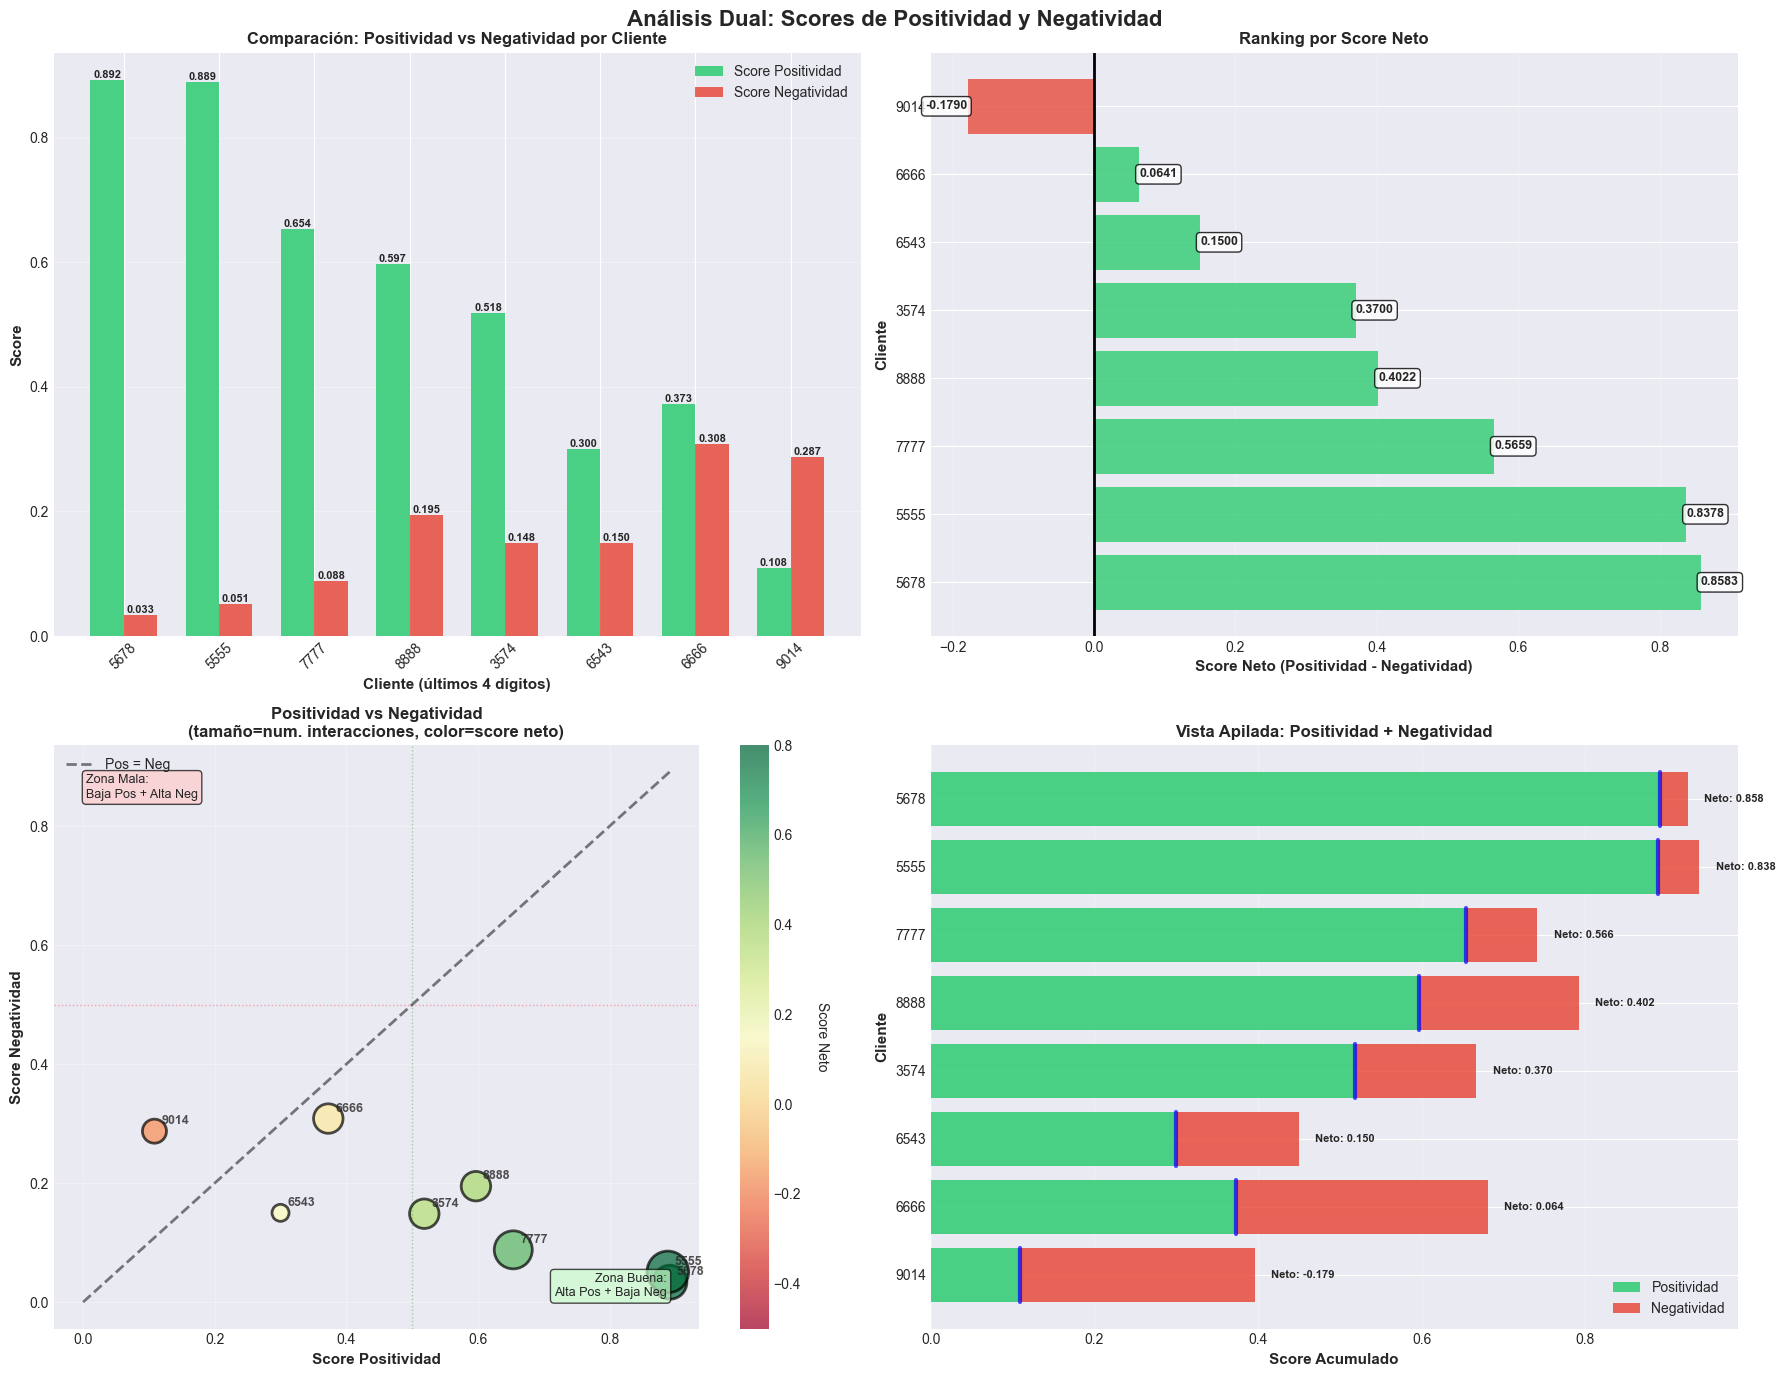


ANÁLISIS ESTADÍSTICO COMPLETO

📊 POSITIVIDAD:
  Media: 0.5413
  Mediana: 0.5577
  Máximo: 0.8917 (Cliente: 5678)
  Mínimo: 0.1084 (Cliente: 9014)

📊 NEGATIVIDAD:
  Media: 0.1576
  Mediana: 0.1492
  Máximo: 0.3085 (Cliente: 6666)
  Mínimo: 0.0334 (Cliente: 5678)

📊 SCORE NETO:
  Media: 0.3837
  Mediana: 0.3861
  Máximo: 0.8583 (Cliente: 5678)
  Mínimo: -0.1790 (Cliente: 9014)

CLASIFICACIÓN DE CLIENTES

🟢 EXCELENTES (Score Neto > 0.6):
  Cliente 5678: Pos=0.892, Neg=0.033, Neto=0.858
  Cliente 5555: Pos=0.889, Neg=0.051, Neto=0.838

🟡 BUENOS (Score Neto 0.3 - 0.6):
  Cliente 3574: Pos=0.518, Neg=0.148, Neto=0.370
  Cliente 8888: Pos=0.597, Neg=0.195, Neto=0.402
  Cliente 7777: Pos=0.654, Neg=0.088, Neto=0.566

🟠 REGULARES (Score Neto 0.0 - 0.3):
  Cliente 6543: Pos=0.300, Neg=0.150, Neto=0.150
  Cliente 6666: Pos=0.373, Neg=0.308, Neto=0.064

🔴 MALOS (Score Neto < 0.0):
  Cliente 9014: Pos=0.108, Neg=0.287, Neto=-0.179

INTERPRETACIÓN
Cada cliente tiene ahora DOS scores independientes:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# DataFrame ficticio
data = {
    'cliente': [
        2617013574,
        266999014,
        2612345678,
        2619876543,
        2618888888,
        2617777777,
        2616666666,
        2615555555
    ],
    'interaccion_positividad': [
        [0.68, 0.56, 0.45],
        [0.12, 0.10],
        [0.85, 0.90, 0.88, 0.92],
        [0.30],
        [0.75, 0.20, 0.65],
        [0.55, 0.58, 0.62, 0.70, 0.75],
        [0.40, 0.38, 0.35],
        [0.95, 0.93, 0.91, 0.89, 0.87, 0.85]
    ],
    'interaccion_negatividad': [
        [0.08, 0.10, 0.20],
        [0.20, 0.35],
        [0.05, 0.03, 0.04, 0.02],
        [0.15],
        [0.10, 0.50, 0.15],
        [0.12, 0.10, 0.09, 0.08, 0.07],
        [0.25, 0.30, 0.35],
        [0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
    ],
    'fecha_interacciones': [
        ['2025-11-01', '2025-11-17', '2025-11-30'],
        ['2025-11-28', '2025-11-30'],
        ['2025-11-15', '2025-11-25', '2025-11-28', '2025-12-01'],
        ['2025-11-05'],
        ['2025-11-01', '2025-11-04', '2025-12-01'],
        ['2025-11-10', '2025-11-29', '2025-12-01', '2025-12-02', '2025-12-03'],
        ['2025-11-20', '2025-12-01', '2025-12-03'],
        ['2025-11-01', '2025-11-05', '2025-11-26', '2025-11-28', '2025-11-30', '2025-12-02']
    ],
    'duracion_s': [
        [60, 600, 50],
        [60, 360],
        [300, 450, 500, 60],
        [180],
        [120, 90, 480],
        [240, 300, 360, 420, 40],
        [200, 150, 100],
        [600, 580, 550, 520, 240, 10]
    ]
}

df = pd.DataFrame(data)

# Parámetros de la simulación
lambda_S = 0.05
C = 600.0
referencia = datetime.now()

print("=" * 120)
print("SIMULACIÓN DE SCORES DE POSITIVIDAD Y NEGATIVIDAD")
print("=" * 120)
print(f"Parámetros: λ={lambda_S}, C={C}s")
print(f"Fecha de referencia: {referencia.strftime('%Y-%m-%d')}")
print("=" * 120)

# Calcular scores para cada cliente
resultados = []

for idx, row in df.iterrows():
    cliente = row['cliente']
    inter_pos = row['interaccion_positividad']
    inter_neg = row['interaccion_negatividad']
    fechas = row['fecha_interacciones']
    duraciones = row['duracion_s']
    
    # Calcular AMBOS scores: positividad y negatividad
    score_positividad = score_frac_boost(inter_pos, fechas, duraciones, lambda_S, C, referencia)
    score_negatividad = score_frac_boost(inter_neg, fechas, duraciones, lambda_S, C, referencia)
    
    # Calcular estadísticas adicionales
    fechas_dt = [datetime.fromisoformat(f) for f in fechas]
    dias = [(referencia - f).days for f in fechas_dt]
    
    # Score neto (positividad - negatividad)
    score_neto = score_positividad - score_negatividad
    
    resultados.append({
        'cliente': str(cliente)[-4:],
        'num_interacciones': len(inter_pos),
        'score_positividad': round(score_positividad, 4),
        'score_negatividad': round(score_negatividad, 4),
        'score_neto': round(score_neto, 4),
        'duracion_promedio': int(np.mean(duraciones)),
        'dias_promedio': round(np.mean(dias), 1)
    })

df_resultados = pd.DataFrame(resultados)

# Agregar rankings
df_resultados['ranking_positividad'] = df_resultados['score_positividad'].rank(ascending=False, method='min').astype(int)
df_resultados['ranking_negatividad'] = df_resultados['score_negatividad'].rank(ascending=True, method='min').astype(int)
df_resultados['ranking_neto'] = df_resultados['score_neto'].rank(ascending=False, method='min').astype(int)

print("\n" + "=" * 120)
print("RESULTADOS - SCORES DE POSITIVIDAD Y NEGATIVIDAD")
print("=" * 120)
print(df_resultados[['cliente', 'num_interacciones', 'score_positividad', 'score_negatividad', 
                     'score_neto', 'ranking_neto']].sort_values('ranking_neto').to_string(index=False))

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análisis Dual: Scores de Positividad y Negatividad', fontsize=16, fontweight='bold')

# Gráfico 1: Comparación directa Positividad vs Negatividad
ax1 = axes[0, 0]
df_plot = df_resultados.sort_values('score_neto', ascending=False)
x = np.arange(len(df_plot))
width = 0.35

bars1 = ax1.bar(x - width/2, df_plot['score_positividad'], width, 
                label='Score Positividad', alpha=0.85, color='#2ECC71')
bars2 = ax1.bar(x + width/2, df_plot['score_negatividad'], width, 
                label='Score Negatividad', alpha=0.85, color='#E74C3C')

ax1.set_xlabel('Cliente (últimos 4 dígitos)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Score', fontweight='bold', fontsize=11)
ax1.set_title('Comparación: Positividad vs Negatividad por Cliente', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(df_plot['cliente'], rotation=45)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Gráfico 2: Score Neto (Positividad - Negatividad)
ax2 = axes[0, 1]
colors = ['#2ECC71' if x > 0 else '#E74C3C' for x in df_plot['score_neto']]
bars = ax2.barh(df_plot['cliente'], df_plot['score_neto'], color=colors, alpha=0.8)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax2.set_xlabel('Score Neto (Positividad - Negatividad)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Cliente', fontweight='bold', fontsize=11)
ax2.set_title('Ranking por Score Neto', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# Añadir valores
for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', ha='left' if width > 0 else 'right', 
            va='center', fontweight='bold', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Gráfico 3: Scatter Positividad vs Negatividad
ax3 = axes[1, 0]
scatter = ax3.scatter(df_resultados['score_positividad'], 
                     df_resultados['score_negatividad'],
                     s=df_resultados['num_interacciones']*150,
                     c=df_resultados['score_neto'],
                     cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=2,
                     vmin=-0.5, vmax=0.8)

# Línea diagonal de referencia
max_val = max(df_resultados['score_positividad'].max(), df_resultados['score_negatividad'].max())
ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='Pos = Neg')

ax3.set_xlabel('Score Positividad', fontweight='bold', fontsize=11)
ax3.set_ylabel('Score Negatividad', fontweight='bold', fontsize=11)
ax3.set_title('Positividad vs Negatividad\n(tamaño=num. interacciones, color=score neto)', 
              fontweight='bold', fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Score Neto', rotation=270, labelpad=20)

# Añadir etiquetas
for _, row in df_resultados.iterrows():
    ax3.annotate(row['cliente'], 
                (row['score_positividad'], row['score_negatividad']),
                fontsize=9, fontweight='bold', alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

# Añadir zonas de interpretación
ax3.axhline(y=0.5, color='red', linestyle=':', alpha=0.3, linewidth=1)
ax3.axvline(x=0.5, color='green', linestyle=':', alpha=0.3, linewidth=1)
ax3.text(0.05, 0.95, 'Zona Mala:\nBaja Pos + Alta Neg', 
         transform=ax3.transAxes, fontsize=9, va='top',
         bbox=dict(boxstyle='round', facecolor='#ffcccc', alpha=0.7))
ax3.text(0.95, 0.05, 'Zona Buena:\nAlta Pos + Baja Neg', 
         transform=ax3.transAxes, fontsize=9, va='bottom', ha='right',
         bbox=dict(boxstyle='round', facecolor='#ccffcc', alpha=0.7))

# Gráfico 4: Descomposición por cliente (stacked)
ax4 = axes[1, 1]
df_plot4 = df_resultados.sort_values('score_neto', ascending=True)
y_pos = np.arange(len(df_plot4))

# Crear barras apiladas
bars_pos = ax4.barh(y_pos, df_plot4['score_positividad'], 
                    label='Positividad', alpha=0.85, color='#2ECC71')
bars_neg = ax4.barh(y_pos, df_plot4['score_negatividad'], 
                    left=df_plot4['score_positividad'],
                    label='Negatividad', alpha=0.85, color='#E74C3C')

ax4.set_yticks(y_pos)
ax4.set_yticklabels(df_plot4['cliente'])
ax4.set_xlabel('Score Acumulado', fontweight='bold', fontsize=11)
ax4.set_ylabel('Cliente', fontweight='bold', fontsize=11)
ax4.set_title('Vista Apilada: Positividad + Negatividad', fontweight='bold', fontsize=12)
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(True, alpha=0.3, axis='x')

# Añadir línea del score neto
for i, (idx, row) in enumerate(df_plot4.iterrows()):
    score_neto = row['score_neto']
    ax4.plot([row['score_positividad'], row['score_positividad']], 
             [i-0.4, i+0.4], 'b-', linewidth=3, alpha=0.7)
    ax4.text(row['score_positividad'] + row['score_negatividad'] + 0.02, i,
            f"Neto: {score_neto:.3f}", va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis estadístico completo
print("\n" + "=" * 120)
print("ANÁLISIS ESTADÍSTICO COMPLETO")
print("=" * 120)
print("\n📊 POSITIVIDAD:")
print(f"  Media: {df_resultados['score_positividad'].mean():.4f}")
print(f"  Mediana: {df_resultados['score_positividad'].median():.4f}")
print(f"  Máximo: {df_resultados['score_positividad'].max():.4f} (Cliente: {df_resultados.loc[df_resultados['score_positividad'].idxmax(), 'cliente']})")
print(f"  Mínimo: {df_resultados['score_positividad'].min():.4f} (Cliente: {df_resultados.loc[df_resultados['score_positividad'].idxmin(), 'cliente']})")

print("\n📊 NEGATIVIDAD:")
print(f"  Media: {df_resultados['score_negatividad'].mean():.4f}")
print(f"  Mediana: {df_resultados['score_negatividad'].median():.4f}")
print(f"  Máximo: {df_resultados['score_negatividad'].max():.4f} (Cliente: {df_resultados.loc[df_resultados['score_negatividad'].idxmax(), 'cliente']})")
print(f"  Mínimo: {df_resultados['score_negatividad'].min():.4f} (Cliente: {df_resultados.loc[df_resultados['score_negatividad'].idxmin(), 'cliente']})")

print("\n📊 SCORE NETO:")
print(f"  Media: {df_resultados['score_neto'].mean():.4f}")
print(f"  Mediana: {df_resultados['score_neto'].median():.4f}")
print(f"  Máximo: {df_resultados['score_neto'].max():.4f} (Cliente: {df_resultados.loc[df_resultados['score_neto'].idxmax(), 'cliente']})")
print(f"  Mínimo: {df_resultados['score_neto'].min():.4f} (Cliente: {df_resultados.loc[df_resultados['score_neto'].idxmin(), 'cliente']})")

# Clasificación de clientes
print("\n" + "=" * 120)
print("CLASIFICACIÓN DE CLIENTES")
print("=" * 120)

print("\n🟢 EXCELENTES (Score Neto > 0.6):")
excelentes = df_resultados[df_resultados['score_neto'] > 0.6]
if len(excelentes) > 0:
    for _, row in excelentes.iterrows():
        print(f"  Cliente {row['cliente']}: Pos={row['score_positividad']:.3f}, Neg={row['score_negatividad']:.3f}, Neto={row['score_neto']:.3f}")
else:
    print("  Ninguno")

print("\n🟡 BUENOS (Score Neto 0.3 - 0.6):")
buenos = df_resultados[(df_resultados['score_neto'] >= 0.3) & (df_resultados['score_neto'] <= 0.6)]
if len(buenos) > 0:
    for _, row in buenos.iterrows():
        print(f"  Cliente {row['cliente']}: Pos={row['score_positividad']:.3f}, Neg={row['score_negatividad']:.3f}, Neto={row['score_neto']:.3f}")
else:
    print("  Ninguno")

print("\n🟠 REGULARES (Score Neto 0.0 - 0.3):")
regulares = df_resultados[(df_resultados['score_neto'] >= 0.0) & (df_resultados['score_neto'] < 0.3)]
if len(regulares) > 0:
    for _, row in regulares.iterrows():
        print(f"  Cliente {row['cliente']}: Pos={row['score_positividad']:.3f}, Neg={row['score_negatividad']:.3f}, Neto={row['score_neto']:.3f}")
else:
    print("  Ninguno")

print("\n🔴 MALOS (Score Neto < 0.0):")
malos = df_resultados[df_resultados['score_neto'] < 0.0]
if len(malos) > 0:
    for _, row in malos.iterrows():
        print(f"  Cliente {row['cliente']}: Pos={row['score_positividad']:.3f}, Neg={row['score_negatividad']:.3f}, Neto={row['score_neto']:.3f}")
else:
    print("  Ninguno")

print("\n" + "=" * 120)
print("INTERPRETACIÓN")
print("=" * 120)
print("Cada cliente tiene ahora DOS scores independientes:")
print("  • Score de Positividad: Promedio ponderado de sentimientos positivos")
print("  • Score de Negatividad: Promedio ponderado de sentimientos negativos")
print("  • Score Neto: Positividad - Negatividad (métrica de calidad global)")
print("\nAmbos scores utilizan los mismos pesos (recencia + duración)")
print("Un cliente ideal tiene: Alta Positividad + Baja Negatividad = Score Neto Alto")
print("=" * 120)